In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import gpytorch.kernels as kernels

from time_series_generator import SyntheticTimeSeriesGenerator
from time_series_dataset import TimeSeriesDataset
from gp_kernel_factory import build_kernel
from curriculum_sampler import CurriculumSampler


import gp_plotting as gpplt



# Generate Data

In [2]:
generator = SyntheticTimeSeriesGenerator(
    num_series=10,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.2,
    low_signal_scale=0.02,
    seed=42
)


In [3]:
df = generator.generate()
df.head()

,series_id,timestep,value,long_term,short_term,seasonal,noise,signal_strength
0,0,0,0.623134,-0.304745,0.356749,0.619443,-0.048312,high
1,0,1,0.667371,-0.289607,0.418308,0.595653,-0.056983,high
2,0,2,0.480881,-0.274396,0.452055,0.512382,-0.209160,high
3,0,3,0.689938,-0.259115,0.444735,0.377945,0.126374,high
4,0,4,0.356662,-0.243770,0.396213,0.205768,-0.001548,high


In [4]:
# Generate data
df = generator.generate()

# Create dataset (return trend components later if needed)
dataset = TimeSeriesDataset(df)

# Mini-batch 4 time series at a time
batch_size = 4
T = df['timestep'].unique().shape[0]  # Number of timesteps
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example training loop
for batch_x, batch_y in loader:
    print(batch_x.shape) #: [batch_size, T, 1]
    print(batch_y.shape) #: [batch_size, T]
    pass

torch.Size([4, 100, 1])
torch.Size([4, 100])
torch.Size([4, 100, 1])
torch.Size([4, 100])
torch.Size([2, 100, 1])
torch.Size([2, 100])


# Viz Data

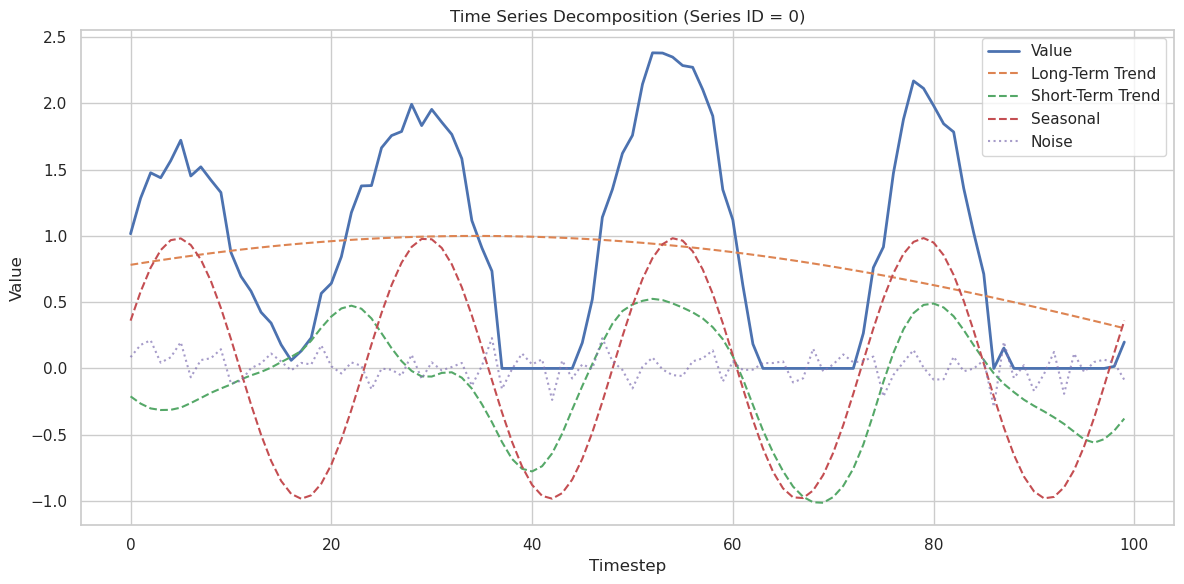

In [5]:
import gp_plotting as gpplt

# Plot a single series with components
gpplt.plot_single_series(df, series_id=0)


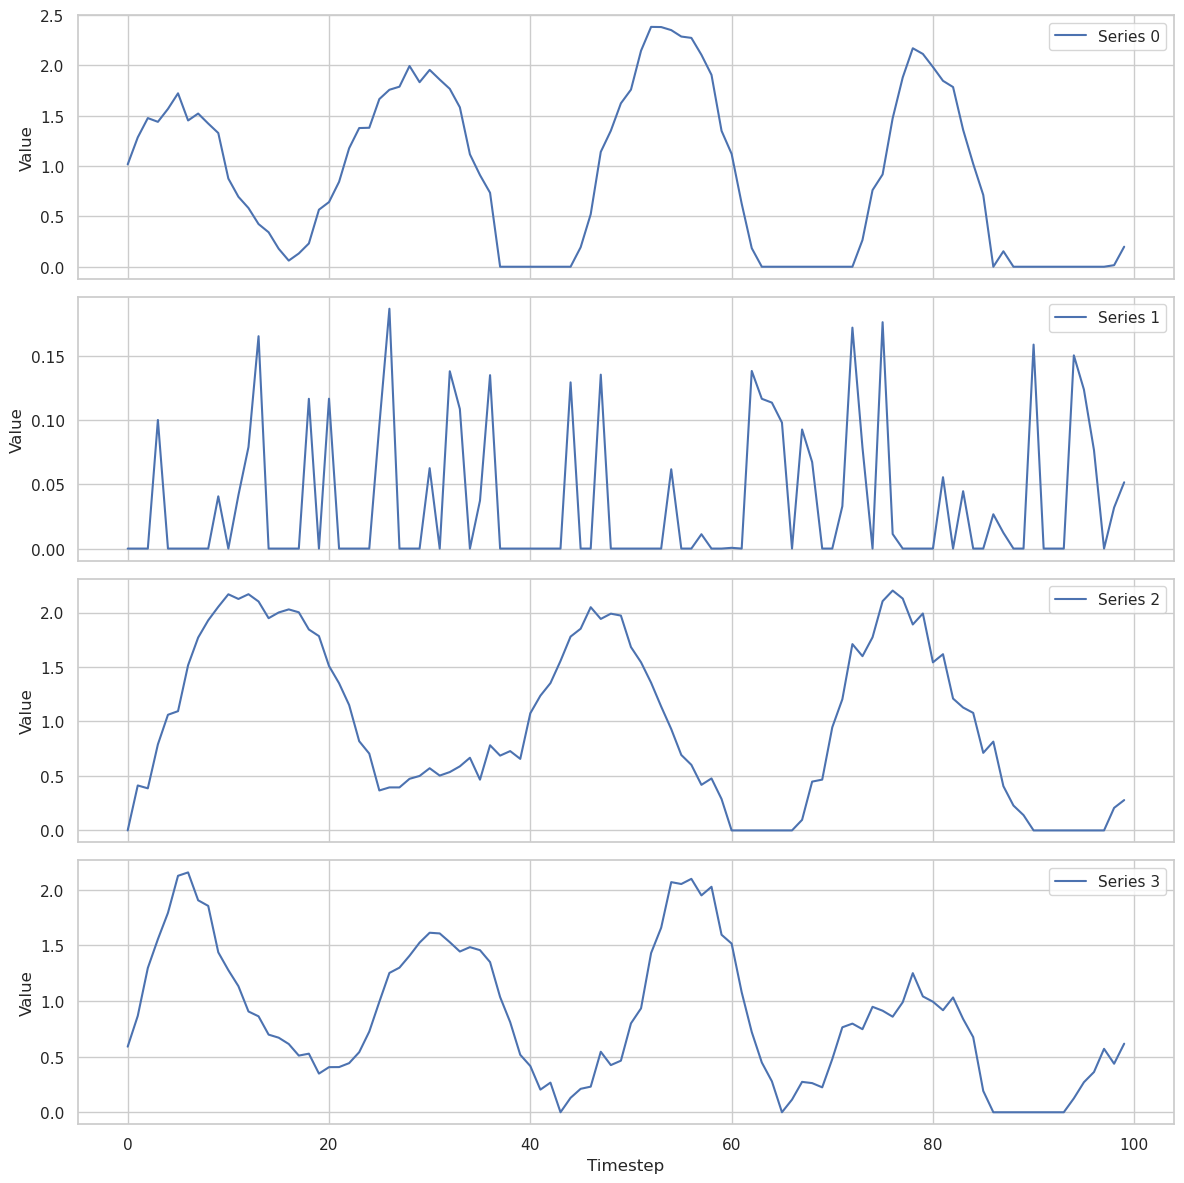

In [6]:
# Plot the first 4 series (just raw value)
gpplt.plot_multiple_series(df, n=4)


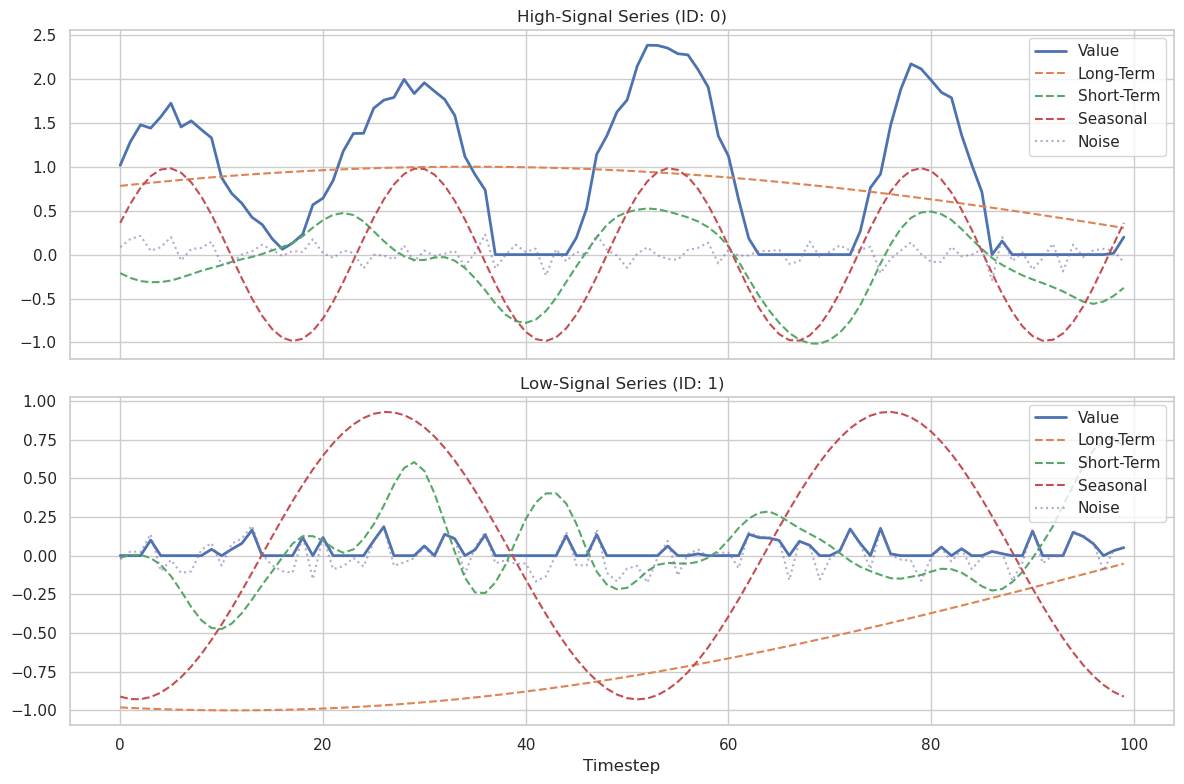

In [7]:
# Visualize high vs low signal comparison
gpplt.plot_signal_vs_noise_comparison(df)

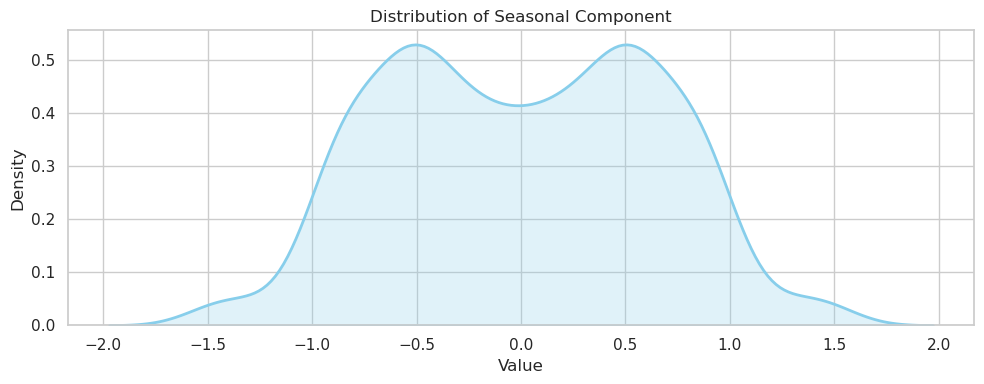

In [8]:
gpplt.plot_component_distributions(df, component="seasonal")


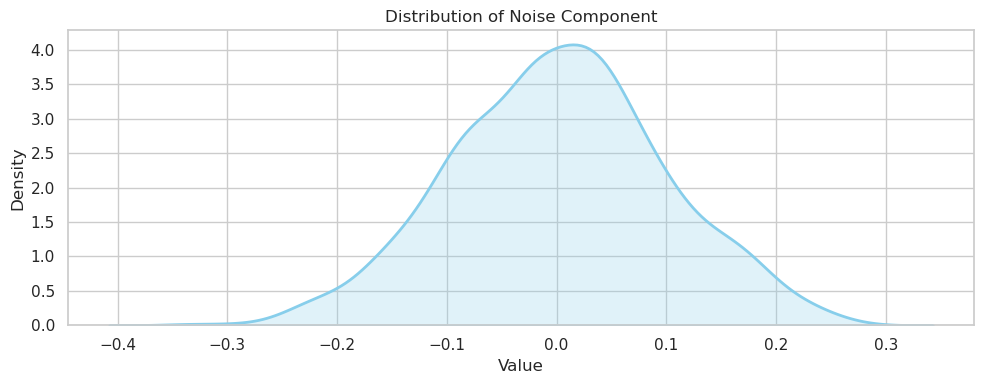

In [9]:
gpplt.plot_component_distributions(df, component="noise")


# Kernel

### 🔁 Swappable Kernel Types (Documented for You)

Here’s what can go into `"type"` for each base kernel:

| Type         | Description |
|--------------|-------------|
| `"RBF"`      | Very smooth (infinitely differentiable) |
| `"Matern"`   | Less smooth, tunable via `nu` |
| `"Periodic"` | Repeating signals |
| `"Linear"`   | Linear relationships (e.g., trends) |
| `"Polynomial"` (planned) | Non-linear but monotonic structure |
| `"Constant"` | Adds a bias term |
| `"Scale"`    | Wrapper to set outputscale |
| `"Add"` / `"Product"` | Composite kernels (combine other kernels) |

I’ll support `Matern` with user-defined `nu`, and make that default for short-term.


In [10]:
kernel_config = {
    "type": "add",  # Composite kernel: sum of all components
    "components": [
        # --- Long-Term Trend ---
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.3},
            "base_kernel": {
                "type": "RBF",  # Radial basis function = smooth global trend
                "lengthscale_prior": {"mean": 2.0, "stddev": 0.5}
            }
        },

        # --- Short-Term Trend ---
        {
            "type": "scale",
            "outputscale_prior": {"mean": 0.5, "stddev": 0.2},
            "base_kernel": {
                "type": "Matern",  # Local, less smooth trend — good for noise-like short-term structure
                "nu": 2.5,         # ν=2.5 is common; alternatives: 1.5 or 0.5 (less smooth)
                "lengthscale_prior": {"mean": 0.2, "stddev": 0.1}
            }
        },

        # --- Seasonal Trend ---
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.1},
            "base_kernel": {
                "type": "Periodic",  # Repeating seasonal pattern
                "period_length": 0.25,
                "lengthscale_prior": {"mean": 0.3, "stddev": 0.1}
            }
        }
    ]
}


In [11]:
# Assume kernel_config from earlier (with Matern short-term trend)
kernel = build_kernel(kernel_config)

print(kernel)
# This is now a fully usable GPyTorch kernel


AdditiveKernel(
  (kernels): ModuleList(
    (0): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (lengthscale_prior): NormalPrior()
      )
      (raw_outputscale_constraint): Positive()
      (outputscale_prior): NormalPrior()
    )
    (1): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Positive()
        (lengthscale_prior): NormalPrior()
      )
      (raw_outputscale_constraint): Positive()
      (outputscale_prior): NormalPrior()
    )
    (2): ScaleKernel(
      (base_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
        (lengthscale_prior): NormalPrior()
      )
      (raw_outputscale_constraint): Positive()
      (outputscale_prior): NormalPrior()
    )
  )
)


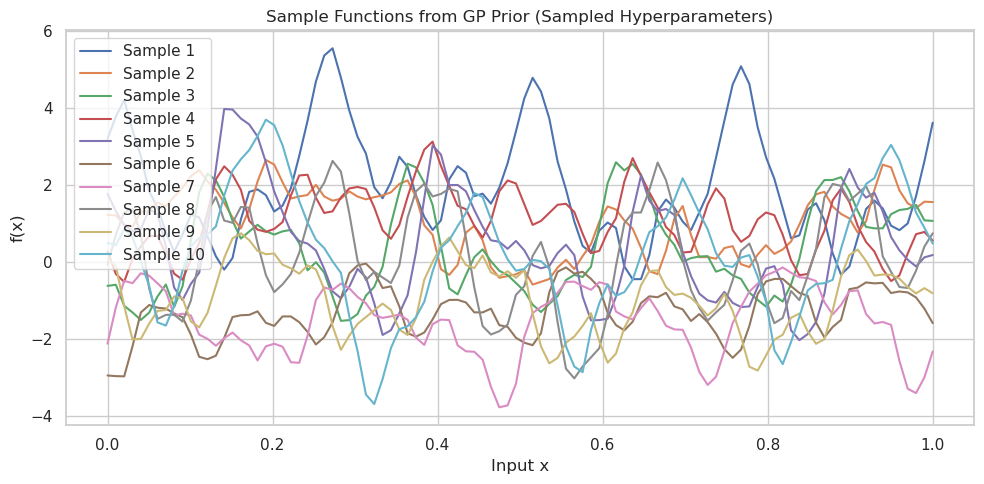

In [12]:
from gp_plotting import plot_kernel_prior_samples

plot_kernel_prior_samples(kernel_config, num_samples=10, seed=42)


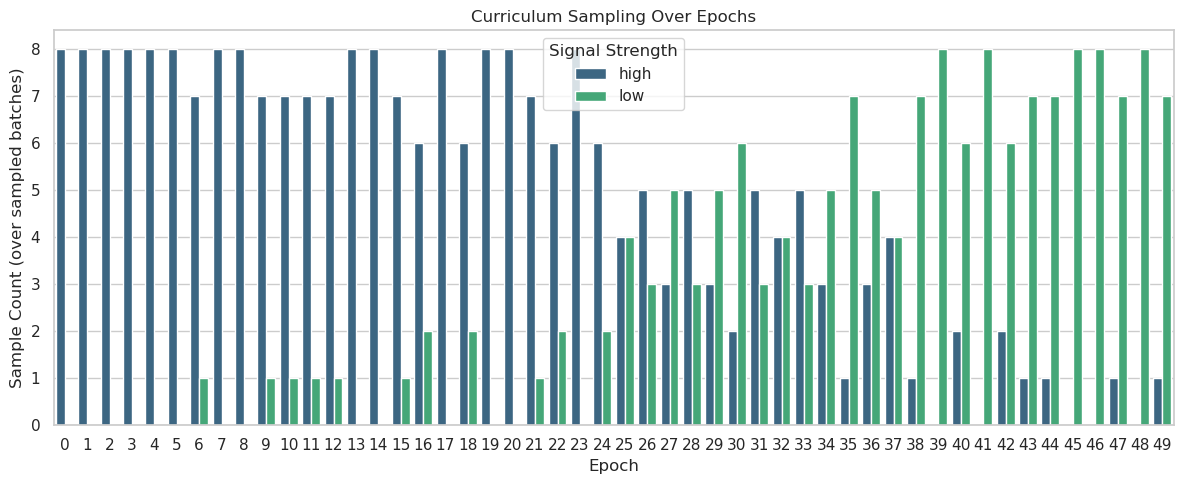

In [19]:
# Create sampler
sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.4,
    max_epochs=30,
    batch_size=8,
    seed=42
)

gpplt.plot_curriculum_progression_over_epochs(
    sampler,
    dataset,
    num_batches=100,
    num_epochs=50
)

In [ ]:


# Set the epoch before each training round
for epoch in range(30):
    sampler.set_epoch(epoch)

    dataloader = DataLoader(
        dataset,
        batch_sampler=sampler
    )
    
    gpplt.plot_curriculum_sampling_distribution(sampler, dataset, num_batches=100, epoch=epoch)   # High signal



In [ ]:






    for x, y in dataloader:
        # Train on batch (x: [B, T, 1], y: [B, T])
        pass
